In [4]:
import numpy as np
import pandas as pd
import covidecg.data.utils
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
import covidecg.models.mlp_models
import skorch
import torch
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from skorch.callbacks import EpochScoring, EarlyStopping
import sklearn.svm
import sklearn.metrics
from sklearn.preprocessing import FunctionTransformer


X, y = covidecg.data.utils.load_stress_ecg_runs('../data/interim/ecg_runs.csv', '../data/interim/ecg_runs')

# pre-process targets
label_encoder = sklearn.preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y).astype(np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# compute class weights for CrossEntropyLoss to mitigate imbalanced classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

0: covid31544_run20210817130741.521
10: covid30818_run20210713132343.746


In [6]:
X.shape, y.shape

((857, 12, 5000), (857,))

Fitting raw_signal__stress_ecg__all_leads__svm_linear
Balanced accuracy: 0.49019607843137253
-----------------------------------------
Fitting raw_signal__stress_ecg__all_leads__svm_polyn
Balanced accuracy: 0.5
-----------------------------------------
Fitting raw_signal__stress_ecg__lead_ii__svm_linear
Balanced accuracy: 0.4529411764705883
-----------------------------------------
Fitting raw_signal__stress_ecg__lead_ii__svm_polyn
Balanced accuracy: 0.5
-----------------------------------------


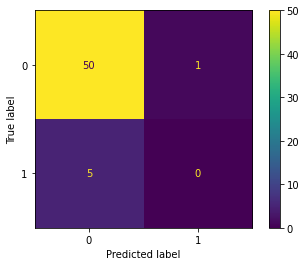

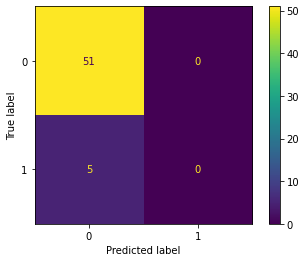

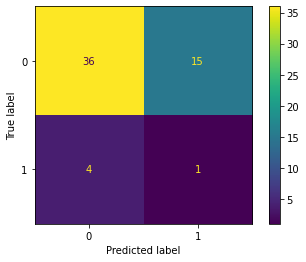

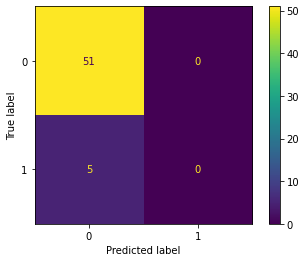

In [10]:
fitted_models = {}

# models to compare
pipe_svm_linear = sklearn.pipeline.Pipeline([
    ('flatten_leads', FunctionTransformer(covidecg.data.utils.flatten_leads)),
    ('SVM (linear kernel)', sklearn.svm.SVC(kernel='linear')),
])
pipe_svm_poly = sklearn.pipeline.Pipeline([
    ('flatten_leads', FunctionTransformer(covidecg.data.utils.flatten_leads)),
    ('SVM (polyn. kernel)', sklearn.svm.SVC(kernel='poly')),
])
pipe_svm_linear_lead_ii = sklearn.pipeline.Pipeline([
    ('select_lead_ii', covidecg.data.utils.EcgLeadSelector('MDC_ECG_LEAD_II')),
    ('SVM (linear kernel)', sklearn.svm.SVC(kernel='linear')),
])

experiments_sklearn = [
    ('raw_signal__stress_ecg__all_leads__svm_linear', pipe_svm_linear),
    ('raw_signal__stress_ecg__all_leads__svm_polyn', pipe_svm_poly),
    ('raw_signal__stress_ecg__lead_ii__svm_linear', pipe_svm_linear_lead_ii),
]
experiments_sklearn.append(('raw_signal__stress_ecg__lead_ii__svm_polyn', 
    sklearn.pipeline.make_pipeline(
        covidecg.data.utils.EcgLeadSelector('MDC_ECG_LEAD_II'), 
        sklearn.svm.SVC(kernel='poly'))))

for _exp_name, _pipe in experiments_sklearn:
    # fit model
    print(f"Fitting {_exp_name}")
    _pipe.fit(X_train, y_train)
    fitted_models[_exp_name] = _pipe
    # evaluate model
    y_pred = _pipe.predict(X_test)
    print("Balanced accuracy:", sklearn.metrics.balanced_accuracy_score(y_test, y_pred))
    sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    print("-----------------------------------------")

In [7]:
# build PyTorch model in skorch wrapper
clf = skorch.NeuralNetClassifier(
    module=covidecg.models.mlp_models.MLP,
    # topology config
    module__input_size=X_train[0].size,  # number of features in flattened sample
    module__hidden_size=1000,
    # loss config
    criterion=nn.CrossEntropyLoss,
    criterion__weight=class_weights,
    # hyperparams
    batch_size=32,
    lr=1e-4,
    optimizer__momentum=0.9,
    max_epochs=10,
    iterator_train__shuffle=True,  # Shuffle training data on each epoch
    callbacks=[
        # additional scores to observe
        EpochScoring(scoring='roc_auc', lower_is_better=False),
        # Early Stopping based on validation loss
        EarlyStopping(patience=3)
        ]
)

experiments_torch = []
fitted_models_torch = {}

experiments_torch.append(('raw_signal__all_leads__mlp',
    sklearn.pipeline.make_pipeline(
        FunctionTransformer(covidecg.data.utils.flatten_leads),
        clf)))

# experiments_torch.append(('raw_signal__lead_ii__mlp',
#     sklearn.pipeline.make_pipeline(
#         FunctionTransformer(covidecg.data.utils.flatten_leads),
#         clf)))

from sklearn.model_selection import cross_val_score
# train the model
for _exp_name, _pipe in experiments_torch:
    print(f"Fitting {_exp_name}")
    cvscore = cross_val_score(_pipe, X=X_train, y=y_train, cv=10, scoring=sklearn.metrics.make_scorer(sklearn.metrics.roc_auc_score))
    # fitted_models_torch[_exp_name] = _pipe

Fitting raw_signal__all_leads__mlp
  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     0.4170        0.7208       0.3710        0.7616  1.4589
      2     0.4768        0.4208       0.5968        0.7686  1.1317
      3     0.4483        0.3646       0.5565        0.7607  1.1418
      4     0.4579        0.3477       0.6129        0.7619  1.2512
      5     0.4640        0.3446       0.6048        0.7646  1.2198
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ---------  ------------  -----------  ------------  ------
      1     0.4114        0.7124       0.4113        0.7620  1.3541
      2     0.4318        0.4069       0.5081        0.7741  1.2416
      3     0.4135        0.3553       0.4516        0.7729  1.2271
Stopping since valid_loss has not improved in the last 3 epochs.
  epoch    roc_auc 

In [10]:
cvscore

array([0.41304348, 0.48913043, 0.54347826, 0.4673913 , 0.51086957,
       0.42588933, 0.45169082, 0.47777778, 0.53043478, 0.42898551])

In [38]:
import matplotlib.pyplot as plt
plt.plot(clf.history[:, 'train_loss'], label='train_loss')
plt.plot(clf.history[:, 'valid_loss'], label='valid_loss')
plt.legend()
plt.show()

TypeError: 'NoneType' object is not subscriptable

/home/scheralph/source/covid-ecg/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


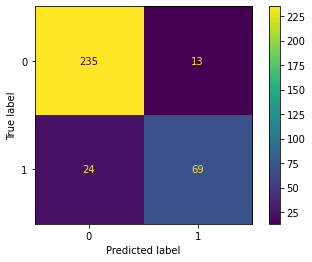

In [33]:
sklearn.metrics.plot_confusion_matrix(pipe, X_test, y_test)